# Topic Modeling

## Content
1. [Settings and Imports](#settings)
2. [Reading the data](#read_data)
3. [Data Prep](#prep)
4. [Vektorization](#vektorization)
5. [Wordclouds](#wordclouds)
6. [Pipeline](#pipeline)

## Settings and Imports <a name="settings"></a>

In [1]:
# Print out every value 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

import string
from wordcloud import WordCloud

%matplotlib inline

In [3]:
import spacy
import gensim.matutils
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models import LsiModel
from gensim.models import nmf

## Reading the data <a name="read_data"></a>

In [4]:
con = sqlite3.connect('./data/reddit_crypto_posts.sqlite')
df = pd.read_sql_query("SELECT * from post_data", con)
con.close()

#print some stats of the data 
print(df.head())

   index       subreddit                author  \
0      0  CryptoCurrency            jonbristow   
1      1  CryptoCurrency           BTC_Hadzija   
2      2  CryptoCurrency  GroundbreakingLack78   
3      3  CryptoCurrency           nanooverbtc   
4      4  CryptoCurrency       Hot_Dog_Dudeson   

                                               title  \
0  You hear about the kid who put in $500 into a ...   
1  It's been a crazy ride these past 7 years, but...   
2  Elon Musk Is Not One Of Us. Stop Using Him As ...   
3  How much will the price of Litecoin move by Mo...   
4  Elon Musks affect on crypto is completely exag...   

                                                text  upvotes  downvotes  \
0  You hear about the kid who put in $500 into a ...    51533          0   
1  I'm tired of holding an asset that I'm always ...    36631          0   
2  I’m tired of seeing him as a face of crypto in...    36154          0   
3  Reference price: $297.69\n\n[Data will be sour...    28

## Data Prep <a name="prep"></a>

For Topic Modeling, we only keep the Nouns and Pronouns, because they best define the different topics. Also the tokens are normalized, because for this is use case it doesn't matter if e.g. a word is in singular or plural form.

In [5]:
# define space nlp with just the tagger (includes lemmatizer)
nlp_spacy = spacy.load('en_core_web_trf')
nlp_spacy.Defaults.stop_words |= set(string.punctuation)

#tokenization and pre-processing with spacy
def tokenize(text):
    spacy_doc = nlp_spacy(text)
    # append the lemma of the tokes if they are a noun
    tokens = [token.lemma_ for token in spacy_doc if token.pos_ in ['NOUN', 'PROPN']]
    
    # remove stop-words
    tokens = [token.lower() for token in tokens if token.lower() not in nlp_spacy.Defaults.stop_words]
    
    #filter tokens which are too long
    tokens = [token for token in tokens if len(token)<25]
    return tokens

In [6]:
%%time
tokens= []
for index, row in df.iterrows():
    tokens.append(tokenize(row['title']) + tokenize(row['text']))
df['tokens'] = tokens

Token indices sequence length is longer than the specified maximum sequence length for this model (905 > 512). Running this sequence through the model will result in indexing errors


Wall time: 50min 17s


In [7]:
df.head()

index       subreddit                author  \
0      0  CryptoCurrency            jonbristow   
1      1  CryptoCurrency           BTC_Hadzija   
2      2  CryptoCurrency  GroundbreakingLack78   
3      3  CryptoCurrency           nanooverbtc   
4      4  CryptoCurrency       Hot_Dog_Dudeson   

                                               title  \
0  You hear about the kid who put in $500 into a ...   
1  It's been a crazy ride these past 7 years, but...   
2  Elon Musk Is Not One Of Us. Stop Using Him As ...   
3  How much will the price of Litecoin move by Mo...   
4  Elon Musks affect on crypto is completely exag...   

                                                text  upvotes  downvotes  \
0  You hear about the kid who put in $500 into a ...    51533          0   
1  I'm tired of holding an asset that I'm always ...    36631          0   
2  I’m tired of seeing him as a face of crypto in...    36154          0   
3  Reference price: $297.69\n\n[Data will be sour...    28978          0   
4                                                       28125          0   

             category        creation_time  \
0            STRATEGY  2021-05-08 17:28:35   
1              COMEDY  2021-05-14 21:47:09   
2  FOCUSED-DISCUSSION  2021-04-10 01:30:55   
3              🗳 POLL  2021-05-03 20:27:42   
4               MEDIA  2021-05-20 12:16:50   

                                              tokens  
0  [kid, memecoin, kid, memecoin, guy, memecoin, ...  
1  [ride, year, asset, environment, network, usag...  
2  [elon, musk, role, model, face, crypto, news, ...  
3  [price, litecoin, monday, 10th, reference, pri...  
4  [elon, musks, affect, crypto, press, tweet, im...

## Vektorization <a name="vektorization"></a>

The dataset (better name would be dictionary) maps all existing tokens to a specific ID. This makes working with vectors possible. We add every token from the dataframe to it and thus all tokens in our corpus.

The tfidf_vectorizer can weight the vectors according to the number of appearances in the whole corpus (frequent words are less important).

In [8]:
#create a global dictionary, corpus and tfidf_vectorizer

dataset = corpora.Dictionary()
dataset.add_documents(df['tokens'].tolist())
#dataset.filter_extremes(no_below=0,no_above=0.7)


corpus = [dataset.doc2bow(text) for text in df['tokens'].tolist()]
tfidf_vectorizer = TfidfModel(corpus)

## Topic Modeling <a name="model"></a>

The following method does the following things:  
* Create the Topic Model (lda, lsi or nmf) with an increasing number of topics
* Calculates the Coherence Score (metric to measure quality of a model) for each of them
* Visualizes the Coherence Scores

In [9]:
def evaluate_graph(dataframe,min_topic_num=5,max_topic_num=20, coherence_metric="c_v", model_type ="lda"):
    model_list = []
    coherence_values = []
    
    for topics_num in range(min_topic_num,max_topic_num + 1):
        #Create the Models with increasing number of Topics\
        if model_type == "nmf":
            model = nmf.Nmf(tfidf_vectorizer[corpus], id2word=dataset, num_topics=topics_num)
        elif model_type == "lsi" or model_type == "lsa" :
            model = LsiModel(tfidf_vectorizer[corpus], id2word=dataset, num_topics=topics_num)
        elif model_type == "lda":
            #Lda doesn't use the tfidf vect, because the method itself weigths the words
            model = LdaModel(corpus, id2word=dataset, num_topics=topics_num)
        else:
            print("Model Type not supported. Needs to be one of: ['nmf','lsi','lda']")
            return
        model_list.append(model)
        
        #Gensim only supports LDA models for the coherence model
        #For the NMF or LSI Model, the topics needs to be extracted first
        #NOTE: CoherenceModel wouldn't throw an Exception if another model is provided but would return sometine NaN.
        if model_type == "lda":
            coherence_model = CoherenceModel(model=model, texts=dataframe['tokens'].tolist()
                                         ,dictionary=dataset,coherence=coherence_metric,
                                          window_size=30)
        else:    
            topics_model= [[word for word, prob in topic] for topicid, topic in model.show_topics(formatted=False)]
            #Create the CoherenceModel and evaluate its score
            coherence_model = CoherenceModel(topics=topics_model, texts=dataframe['tokens'].tolist()
                                         ,dictionary=dataset,coherence=coherence_metric,
                                          window_size=30)
        coherence_values.append(coherence_model.get_coherence())
        
    # Show graph
    x = range(min_topic_num, max_topic_num + 1)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("c"), loc='best')
    plt.show()
    return model_list, coherence_values

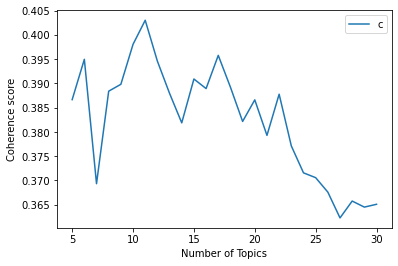

Wall time: 13min 57s


In [10]:
%%time
model_list_lsi, coherence_values_lsi  = evaluate_graph(df,min_topic_num=5,max_topic_num=30, model_type='lsi')
# get the best lsi model
index_value = coherence_values_lsi.index(max(coherence_values_lsi))
best_lsi_model = model_list_lsi[index_value]

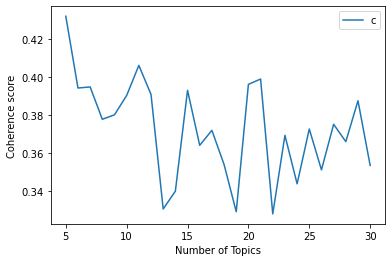

Wall time: 13min 55s


In [11]:
%%time
model_list_nmf, coherence_values_nmf  = evaluate_graph(df,min_topic_num=5,max_topic_num=30, model_type='nmf')
# get the best nmf model
index_value = coherence_values_nmf.index(max(coherence_values_nmf))
best_nmf_model = model_list_nmf[index_value]

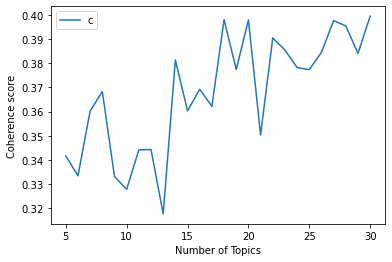

Wall time: 14min 35s


In [12]:
%%time
model_list_lda, coherence_values_lda  = evaluate_graph(df,min_topic_num=5,max_topic_num=30, model_type='lda')
# get the best nmf model
index_value = coherence_values_lda.index(max(coherence_values_lda))
best_lda_model = model_list_lda[index_value]

As seen above, all 3 model types produces model with a coherence score of around 0.4  
This isn't the best, but it's quite okay. This can be due to unstructures writing in reddit posts, where often multiple topics are addressed in the same post.

## Wordclouds <a name="wordclouds"></a>

The most important words of a topic model, can be visualized with wordclouds. These show the most important words as the biggest ones.

In [13]:
def topic_word_cloud(model,num_topic, max_word_count=10):
    wc = WordCloud(width=200, height=100, background_color="white", max_words=max_word_count) 
    # Generierung der Wordcloud
    data = dict(model.show_topic(num_topic,max_word_count))
    wc.generate_from_frequencies(data)
    
    # Plot
    fig=plt.figure(figsize=(6, 3))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

Since Lsi can have also negative values, wordclouds aren't really useful. So we only create them for nmf and lda

Topic 0


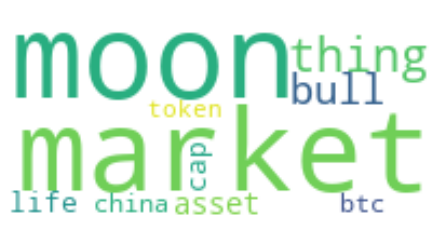

Topic 1


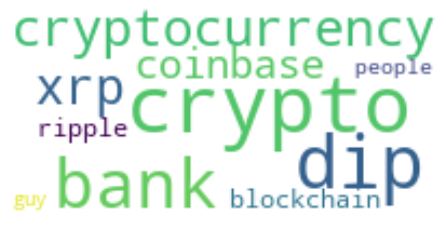

Topic 2


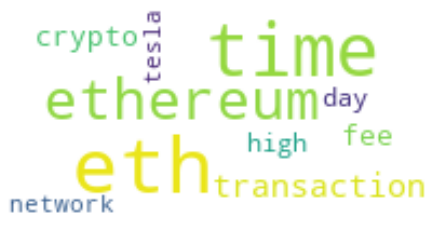

Topic 3


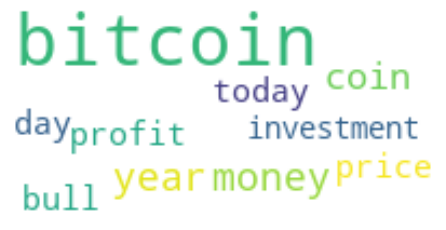

Topic 4


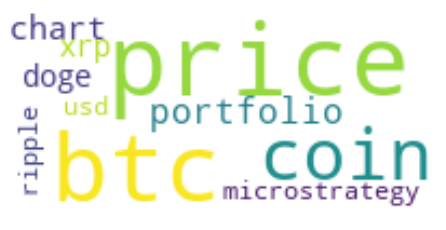

In [14]:
for i in range(best_nmf_model.num_topics):
    print("Topic {0}".format(i))
    topic_word_cloud(best_nmf_model,i,10)

Topic 0


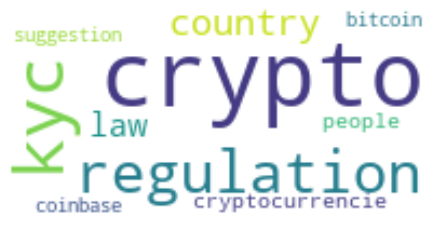

Topic 1


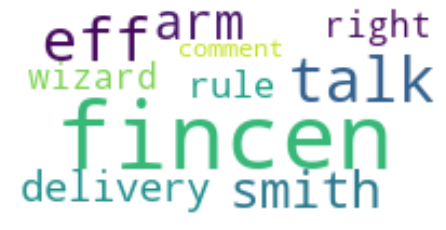

Topic 2


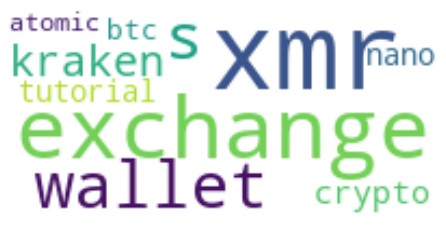

Topic 3


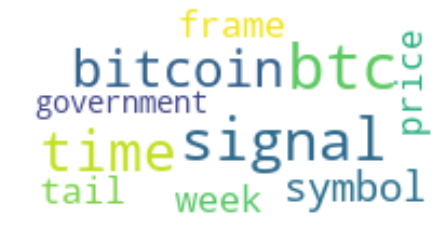

Topic 4


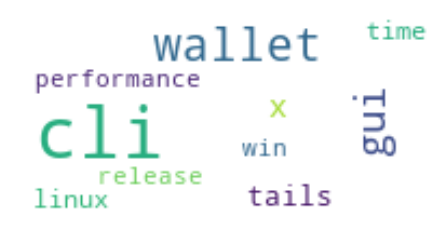

Topic 5


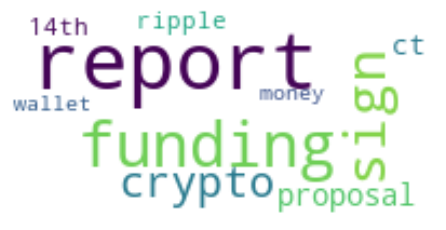

Topic 6


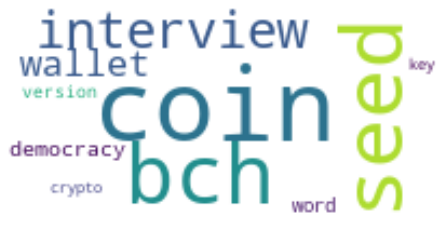

Topic 7


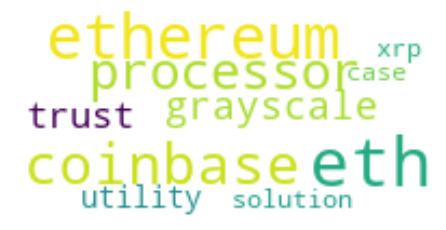

Topic 8


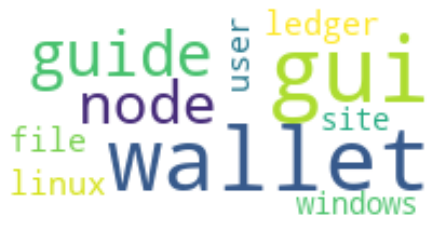

Topic 9


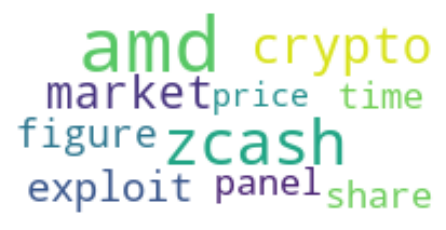

Topic 10


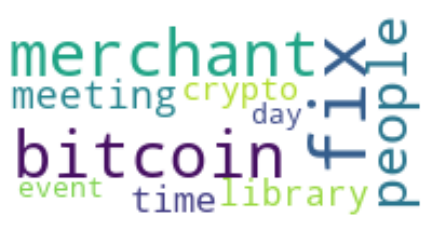

Topic 11


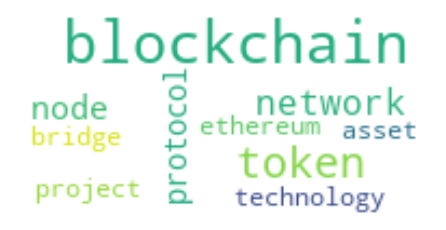

Topic 12


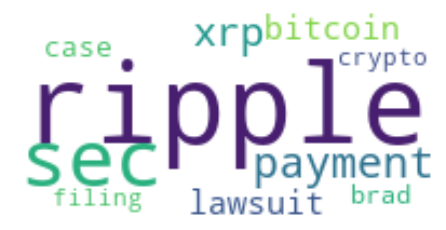

Topic 13


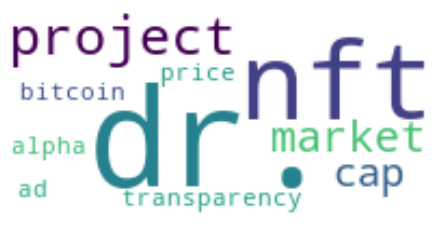

Topic 14


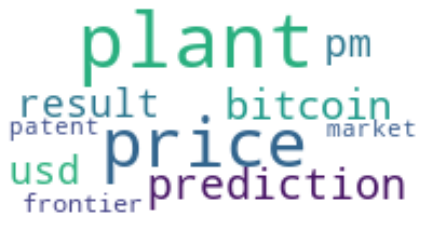

Topic 15


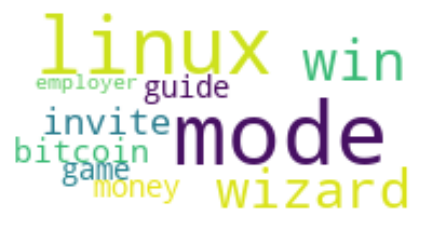

Topic 16


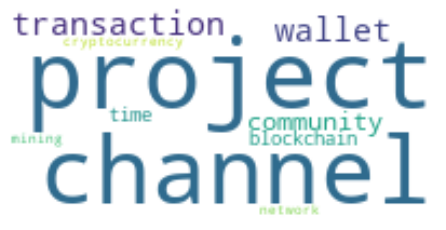

Topic 17


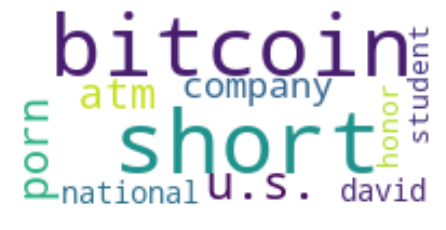

Topic 18


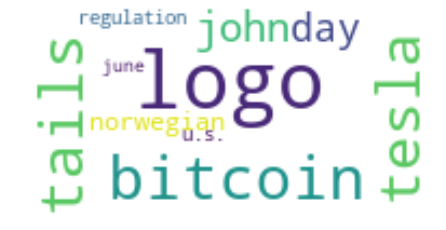

Topic 19


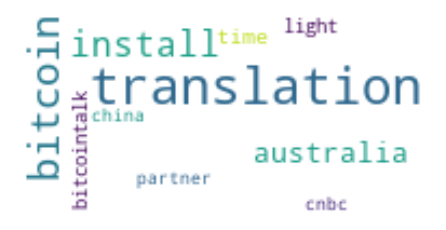

Topic 20


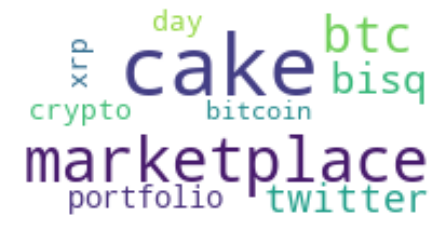

Topic 21


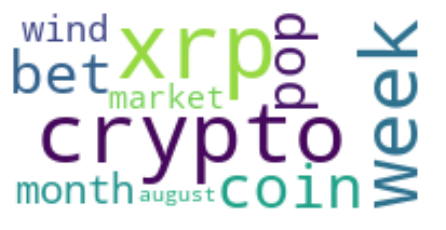

Topic 22


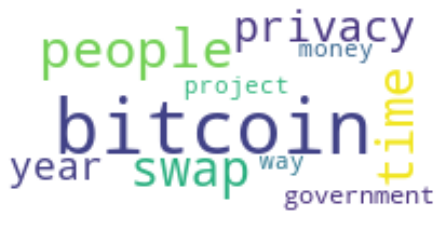

Topic 23


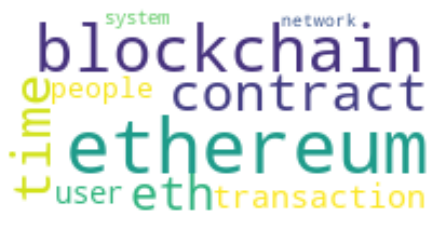

Topic 24


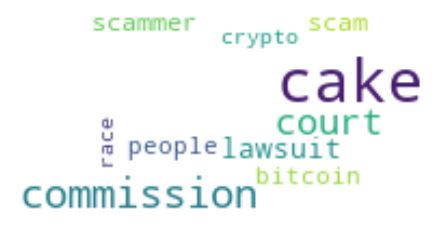

Topic 25


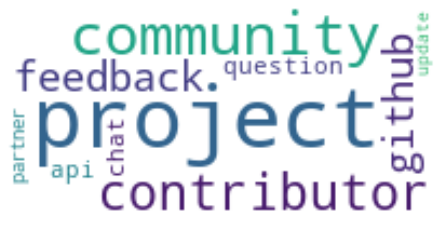

Topic 26


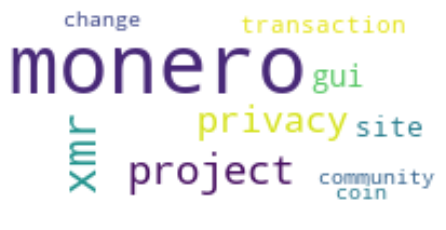

Topic 27


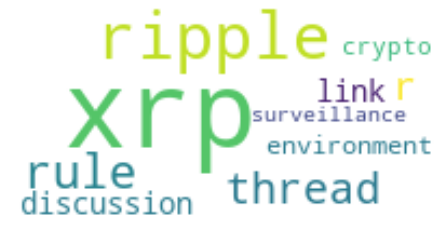

Topic 28


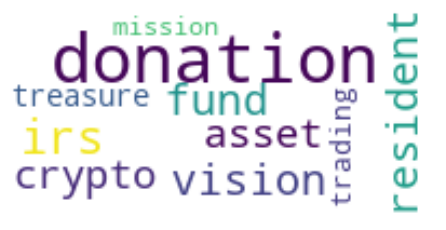

Topic 29


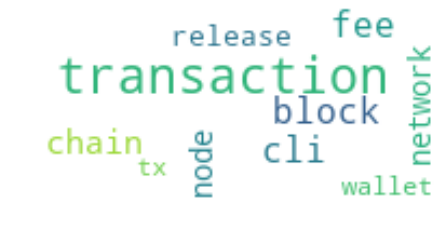

In [15]:
for i in range(best_lda_model.num_topics):
    print("Topic {0}".format(i))
    topic_word_cloud(best_lda_model,i,10)

As seen, some topics makes sense from a human perspective. Let's look at some examples.

* Topic '**Money**': '*price*', '*chart*', '*usd*', '*market*' ...    

* Topic '**Technology**': '*technology*', '*protocol*', '*network*', '*node*' ...  

* Also there are some topics, where a clear heading is hard to define. They have some keywords that could refere to '**privacy**', but some words aren't quite suitable:  '*people*', '*privacy*', '*government*' ...


## Pipeline  <a name="pipeline"></a>

The methods should be chained together, to:  
* Create a model with specified number of topics (for better comparison)
* Create the wordcloud out of them

In [22]:
def create_model(dataframe,topic_num=5,model_type ="lda"):
    #model creation
    if model_type == "nmf":
        model = nmf.Nmf(tfidf_vectorizer[corpus], id2word=dataset, num_topics=topic_num)
    elif model_type == "lsi" or model_type == "lsa" :
        print("Model does not support Wordclouds, cause it can have negative values")
        return LsiModel(tfidf_vectorizer[corpus], id2word=dataset, num_topics=topic_num)
    elif model_type == "lda":
        #Lda doesn't use the tfidf vect, because the method itself weigths the words
        model = LdaModel(corpus, id2word=dataset, num_topics=topic_num)
    else:
        print("Model Type not supported. Needs to be one of: ['nmf','lda'], but was {0}".format(model_type))
        return
    
    #wordclouds
    for i in range(model.num_topics):
        print("Topic nr {0} from {1}-model".format(i,model_type))
        topic_word_cloud(model,i,10) 
    
    return model

The following part creates a topicmodel for each coin subreddit with a fixed number of topics, which can be compared afterwards.

The experiment itself is wrapped in another function, so that it can be repeated with different topic_num or different model_type

In [25]:
def create_model_for_each_coin(num_topics = 5, model = "lda"):
    subreddits = ['Bitcoin','ethereum','Ripple','Monero']
    for subred in subreddits:
        print("Using subreddit {0}".format(subred))
        model_created = create_model(dataframe = df[df['subreddit'].str.contains(subred)],
                             topic_num= num_topics,
                             model_type= model)

Using subreddit Bitcoin
Topic nr 0 from lda-model


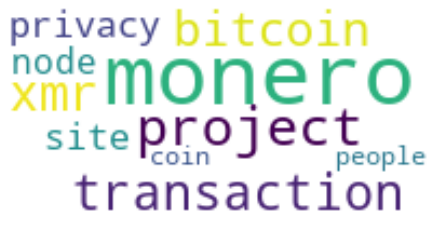

Topic nr 1 from lda-model


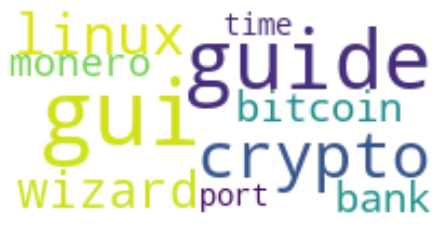

Topic nr 2 from lda-model


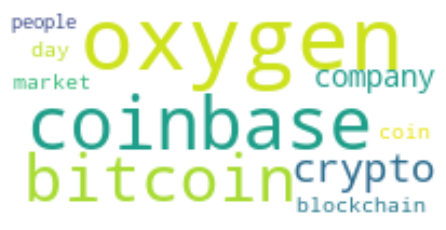

Topic nr 3 from lda-model


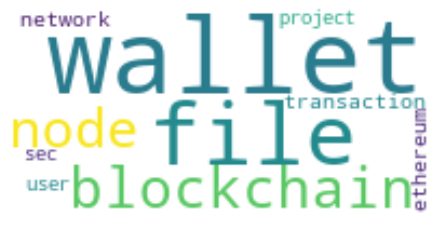

Topic nr 4 from lda-model


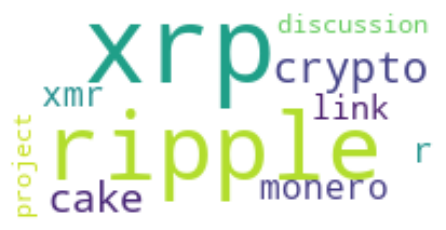

Topic nr 5 from lda-model


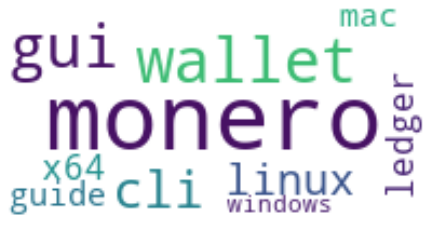

Topic nr 6 from lda-model


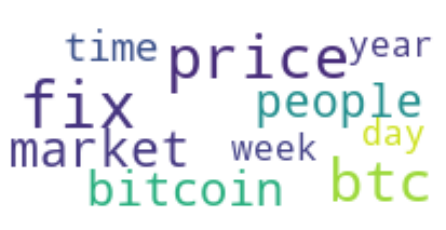

Topic nr 7 from lda-model


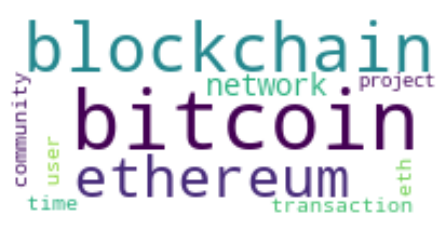

Using subreddit ethereum
Topic nr 0 from lda-model


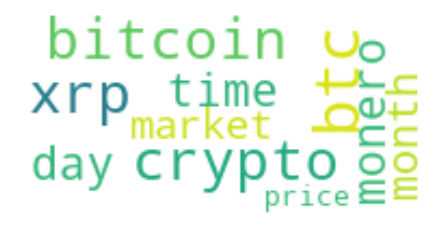

Topic nr 1 from lda-model


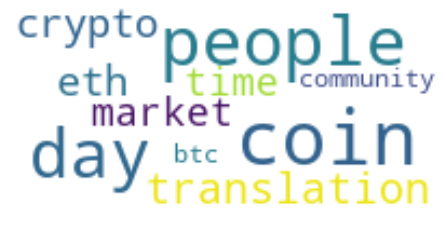

Topic nr 2 from lda-model


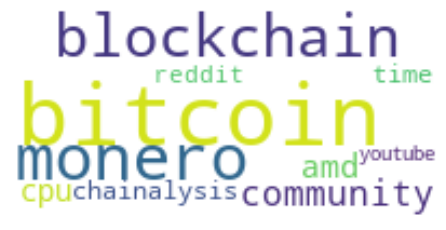

Topic nr 3 from lda-model


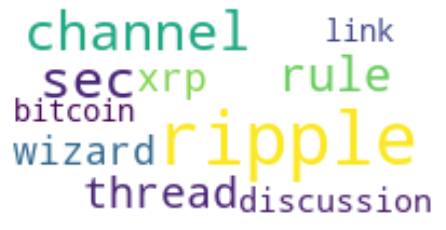

Topic nr 4 from lda-model


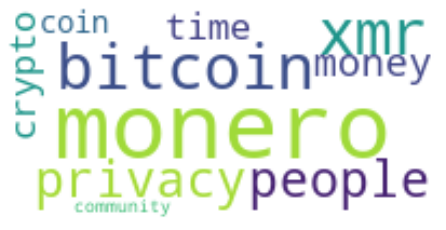

Topic nr 5 from lda-model


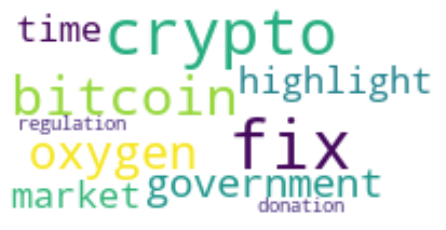

Topic nr 6 from lda-model


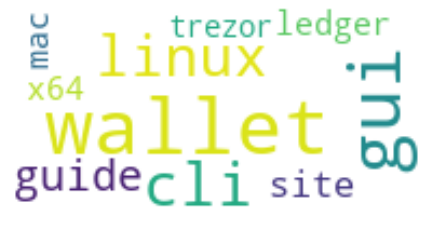

Topic nr 7 from lda-model


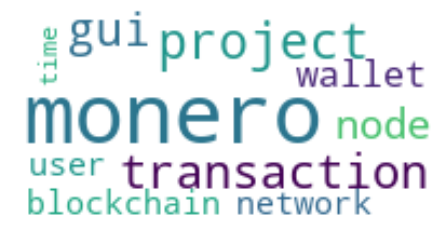

Using subreddit Ripple
Topic nr 0 from lda-model


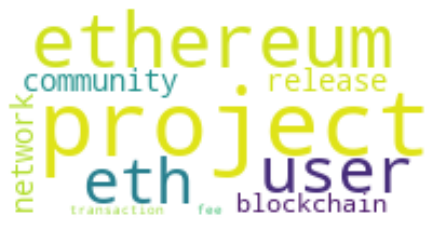

Topic nr 1 from lda-model


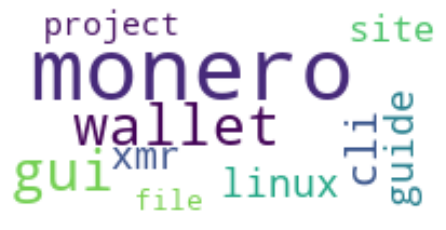

Topic nr 2 from lda-model


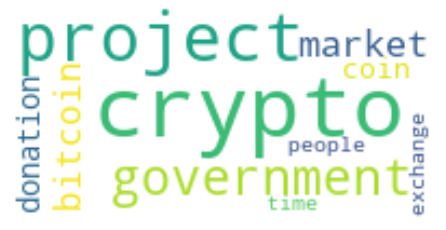

Topic nr 3 from lda-model


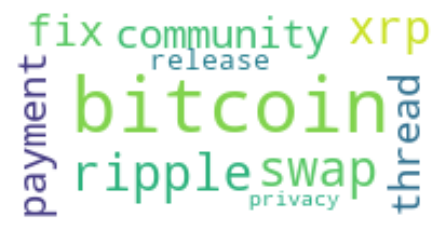

Topic nr 4 from lda-model


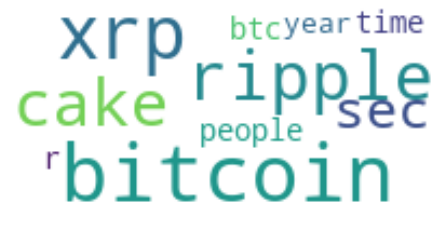

Topic nr 5 from lda-model


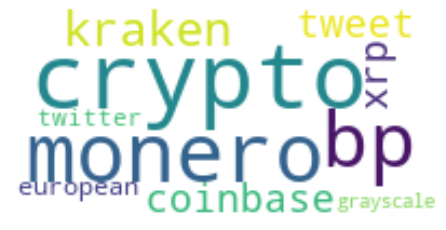

Topic nr 6 from lda-model


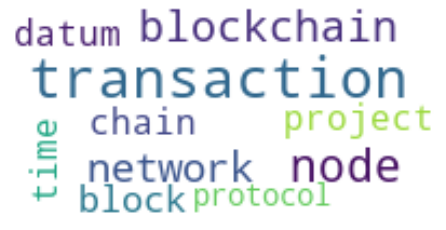

Topic nr 7 from lda-model


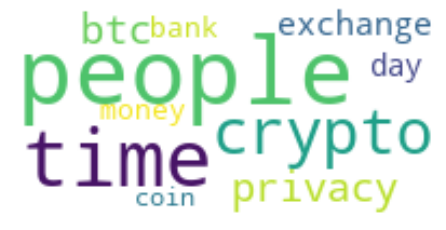

Using subreddit Monero
Topic nr 0 from lda-model


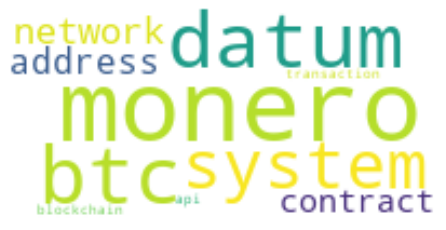

Topic nr 1 from lda-model


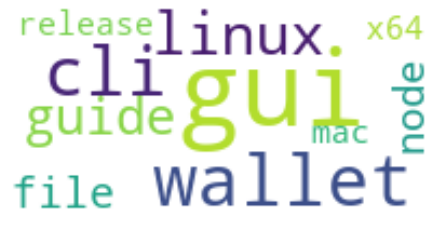

Topic nr 2 from lda-model


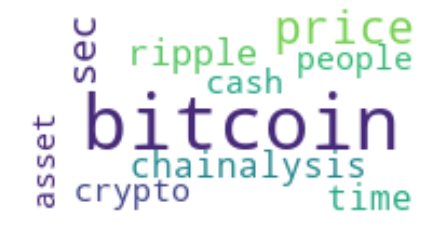

Topic nr 3 from lda-model


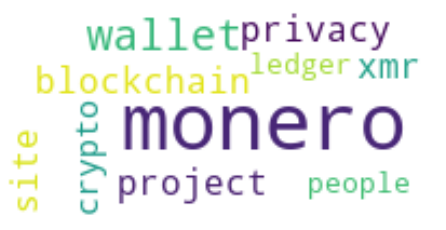

Topic nr 4 from lda-model


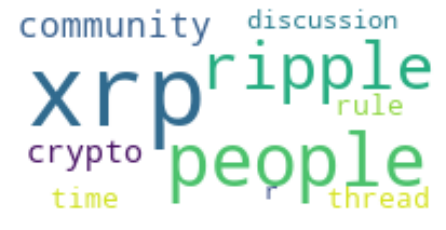

Topic nr 5 from lda-model


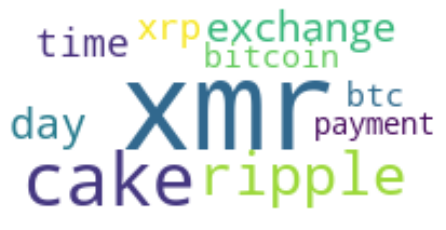

Topic nr 6 from lda-model


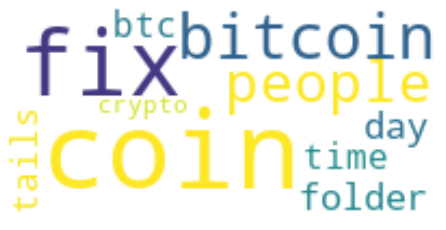

Topic nr 7 from lda-model


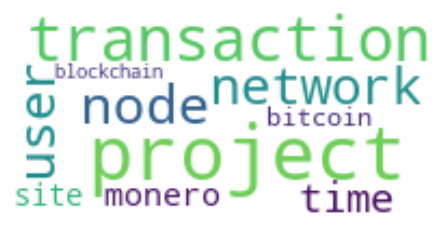

Using subreddit Bitcoin
Topic nr 0 from nmf-model


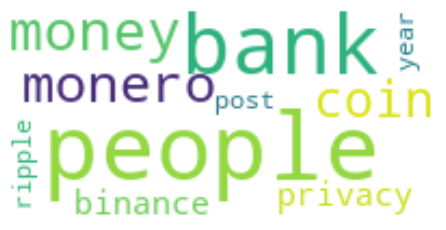

Topic nr 1 from nmf-model


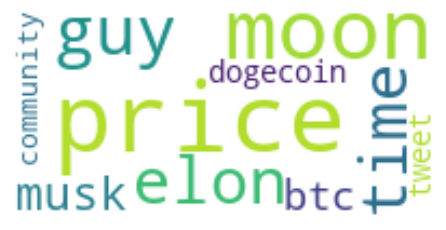

Topic nr 2 from nmf-model


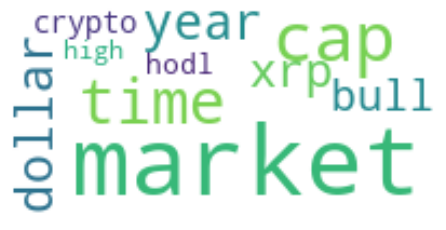

Topic nr 3 from nmf-model


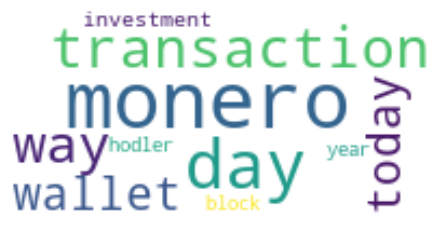

Topic nr 4 from nmf-model


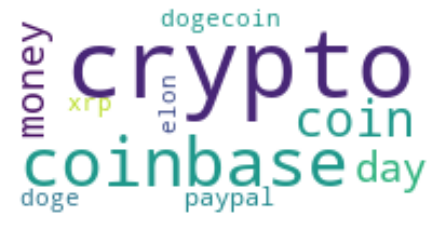

Topic nr 5 from nmf-model


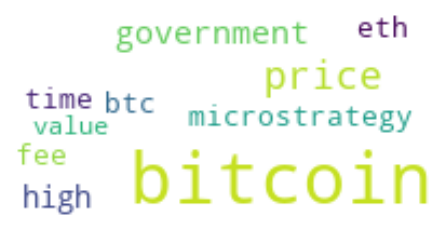

Topic nr 6 from nmf-model


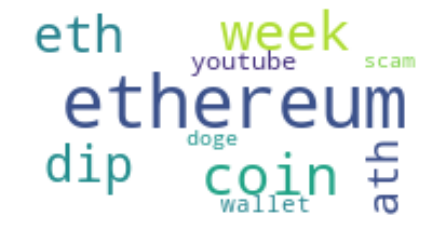

Topic nr 7 from nmf-model


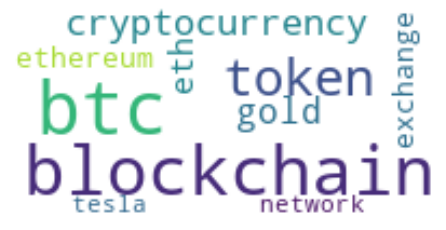

Using subreddit ethereum
Topic nr 0 from nmf-model


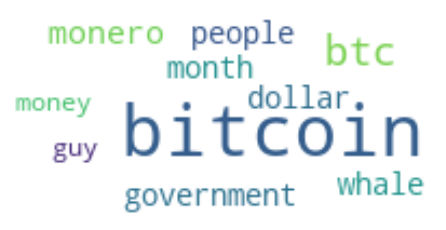

Topic nr 1 from nmf-model


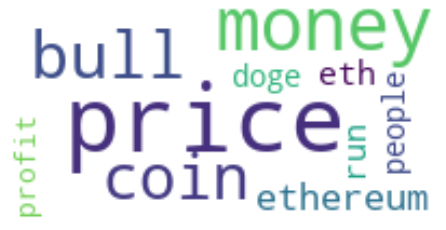

Topic nr 2 from nmf-model


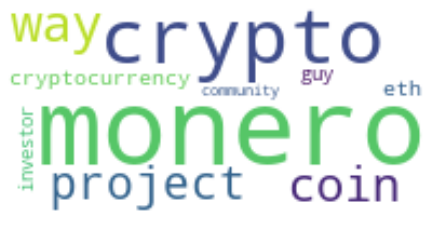

Topic nr 3 from nmf-model


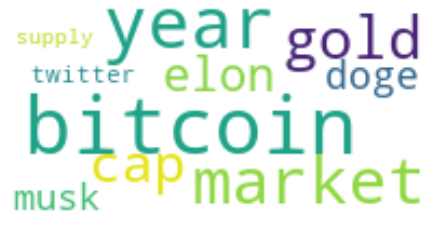

Topic nr 4 from nmf-model


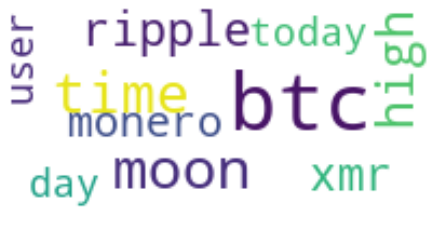

Topic nr 5 from nmf-model


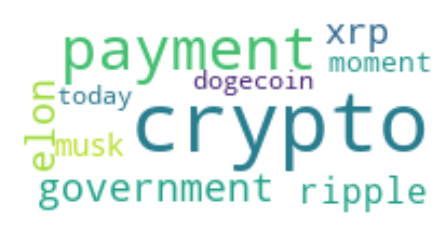

Topic nr 6 from nmf-model


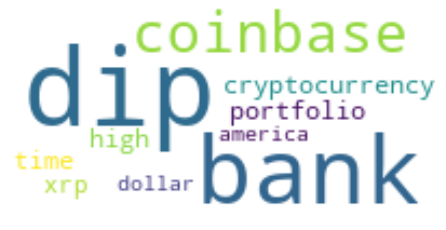

Topic nr 7 from nmf-model


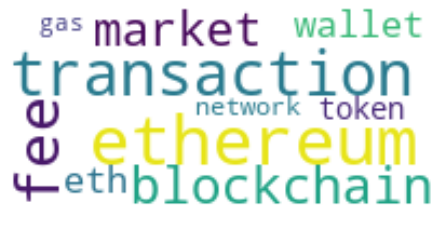

Using subreddit Ripple
Topic nr 0 from nmf-model


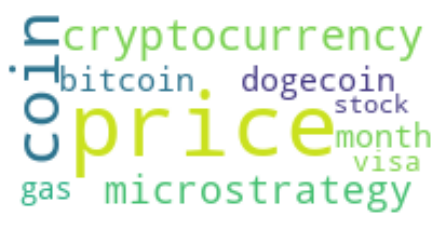

Topic nr 1 from nmf-model


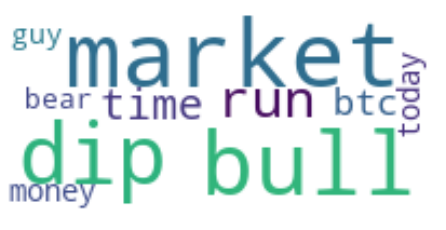

Topic nr 2 from nmf-model


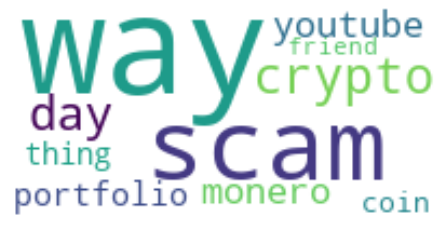

Topic nr 3 from nmf-model


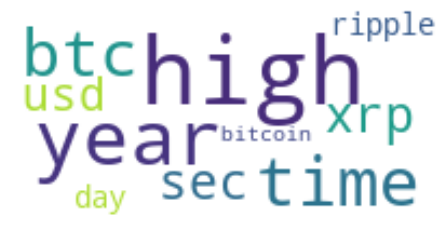

Topic nr 4 from nmf-model


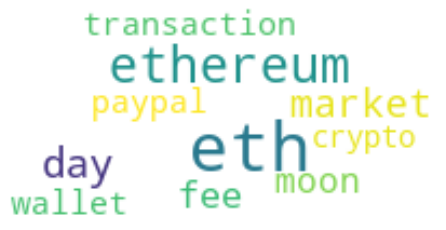

Topic nr 5 from nmf-model


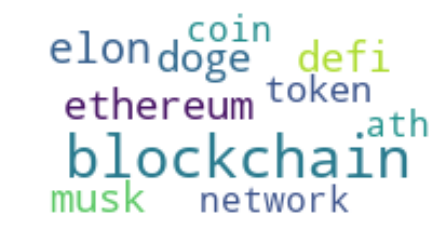

Topic nr 6 from nmf-model


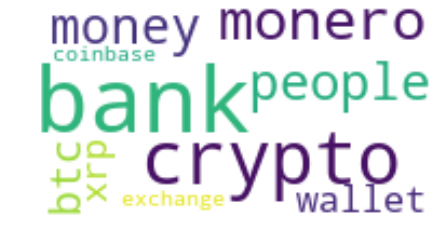

Topic nr 7 from nmf-model


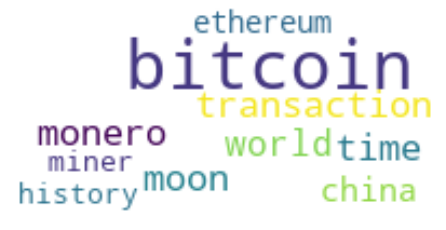

Using subreddit Monero
Topic nr 0 from nmf-model


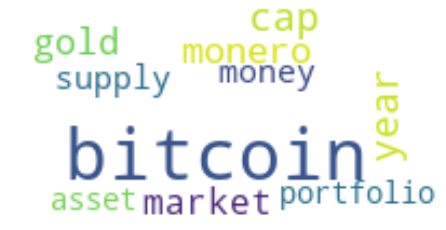

Topic nr 1 from nmf-model


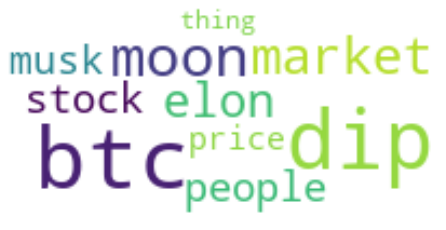

Topic nr 2 from nmf-model


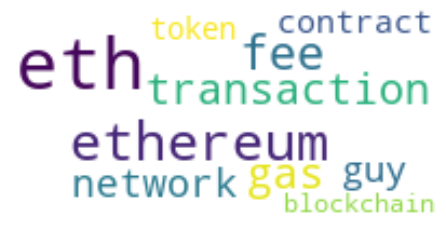

Topic nr 3 from nmf-model


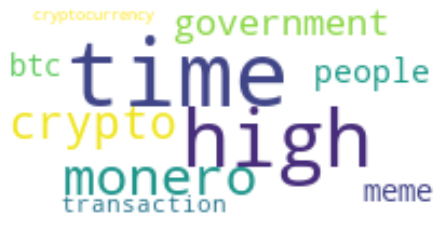

Topic nr 4 from nmf-model


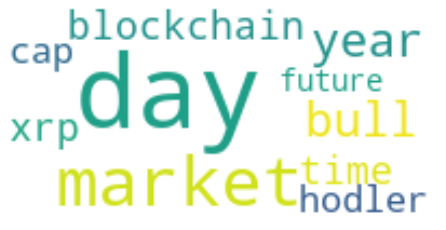

Topic nr 5 from nmf-model


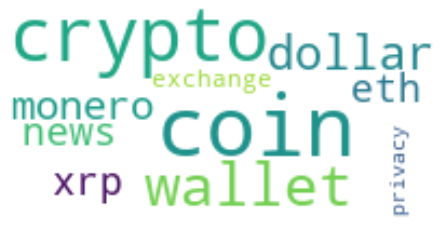

Topic nr 6 from nmf-model


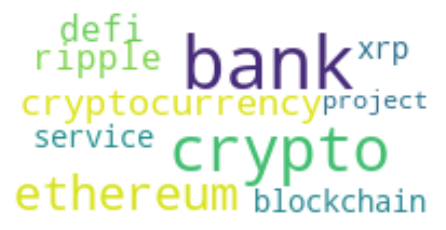

Topic nr 7 from nmf-model


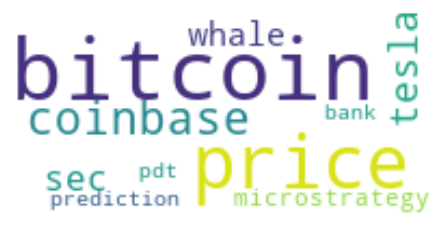

In [26]:
create_model_for_each_coin(num_topics=8,model="lda")
create_model_for_each_coin(num_topics=8,model="nmf")

The different subreddits of each coin have similar topics. Each subreddit e.g. has a topic that (probably) describes **how the coin works**. The words of these are '*node*', '*project*', '*time*', '*blockchain*', '*network*', '*transaction*', ...  

Another topic which each coin has (or at least as a part) , is something around '**money**'. Words like '*price*', '*market*' appear .

A **technolgy** topic also exists for every coin. Some words are quite specific like '*x64*', '*linux*', while other words like '*network*' or '*protocol*' are more generic

[zurück zur Übersicht](./00_TXA-CC_Bericht.ipynb)